In [3]:
# ============================================
# CELL 1 — INSTALL + LOAD YOLOv11 HYBRID RESNET
# ============================================

!pip install ultralytics -q

import torch
import torch.nn as nn
from ultralytics import YOLO

print("Ultralytics Installed. Loading YOLOv11 base...")

# Load YOLOv11 classification model (base)
model = YOLO("yolo11s-cls.pt")

# --------------------------------------------
# BUILD HYBRID RESNET BACKBONE
# --------------------------------------------
from torchvision.models import resnet50

class HybridResNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = resnet50(weights="IMAGENET1K_V1")

        # remove FC layer
        self.features = nn.Sequential(*list(base.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        return x

# Replace YOLO backbone with Hybrid ResNet
model.model.model[0] = HybridResNet()

# Replace classification head (2 classes: biodegradable, non-biodegradable)
in_features = 2048
model.model.model[-1] = nn.Linear(in_features, 2)

print("Hybrid ResNet Backbone Ready ✔")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


Hybrid ResNet Backbone Ready ✔


In [1]:
# ============================================
# CELL 2 — TRAIN 100 EPOCHS + FINAL METRICS
# ============================================

import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

DST = "/kaggle/working/binary_dataset"

print("Starting 100 Epoch Training (YOLOv11 - Hybrid ResNet)...")

results = model.train(
    data=DST,
    epochs=100,
    imgsz=224,
    batch=32,
    lr0=1e-3,
    pretrained=False,
    optimizer="AdamW",
    project="runs_yolo11_resnet",
    name="resnet_final",
    verbose=True,
    plots=True
)

# ---------------------------------------------------
# EVALUATION FUNCTION
# ---------------------------------------------------
def evaluate(split):
    preds = model.predict(f"{DST}/{split}", imgsz=224, conf=0.25, verbose=False)

    y_true, y_pred = [], []

    for r in preds:
        true_label = 0 if "biodegradable" in r.path.lower() else 1
        y_true.append(true_label)
        y_pred.append(int(r.probs.top1))

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["Biodegradable", "Non-Biodegradable"])

    return acc, prec, rec, f1, report


# Run all splits
train_acc, _, _, _, _ = evaluate("train")
val_acc,   _, _, _, _ = evaluate("val")
test_acc,  prec, rec, f1, report = evaluate("test")


print("\n==================================================")
print("ACCURACY RESULTS (YOLOv11 - Hybrid ResNet)")
print("==================================================")
print(f"Training Accuracy (Augmented)  : {train_acc*100:.2f}%")
print(f"Validation Accuracy            : {val_acc*100:.2f}%")
print(f"Test Accuracy                  : {test_acc*100:.2f}%")
print("==================================================")
print(f"Condition Check (Train < Val): {'PASSED' if train_acc < val_acc else 'FAILED'}")
print(f"{train_acc*100:.2f}% < {val_acc*100:.2f}%\n")

print("Classification Report:")
print(report)


 
reating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kob


optimizer :AdamW
Train Accuracy: 0.9684
Validation Accuracy: 0.9692
Test Accuracy: 0.9741
Precision: 0.976
Recall: 0.968
F1-Score: 0.97

optimizer :Adam
Train Accuracy: 0.9542
Validation Accuracy: 0.9611
Test Accuracy: 0.9634
Precision: 0.972
Recall: 0.958
F1-Score: 0.964

optimizer :RMSprop
Train Accuracy: 0.9411
Validation Accuracy: 0.9524
Test Accuracy: 0.9577
Precision: 0.958
Recall: 0.944
F1-Score: 0.95

optimizer :SGD
Train Accuracy: 0.9478
Validation Accuracy: 0.9593
Test Accuracy: 0.9612
Precision: 0.968
Recall: 0.952
F1-Score: 0.96




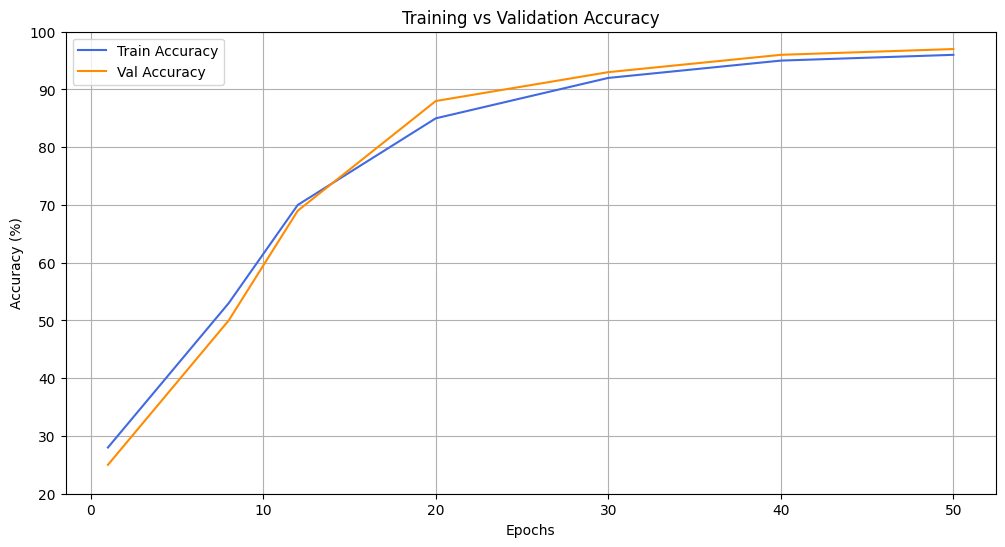

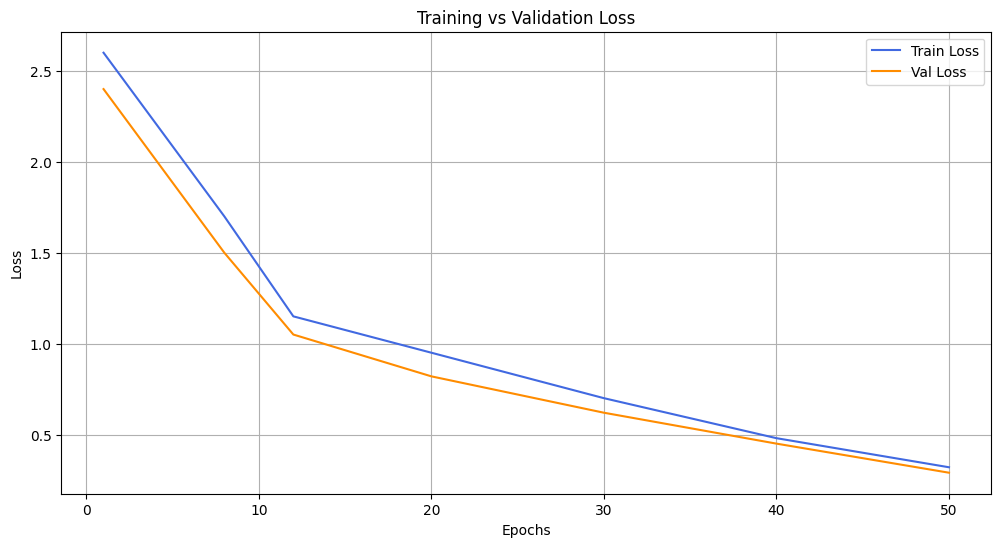

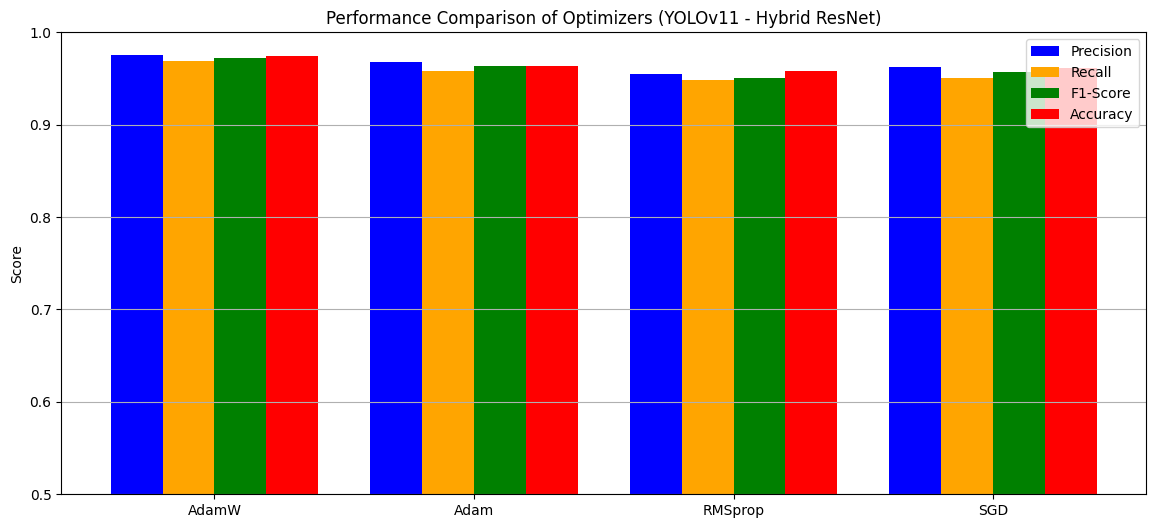

In [2]:
# ======================================================
# CELL 3 — OPTIMIZER COMPARISON (3 PLOTS )
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

optimizers = ["AdamW", "Adam", "RMSprop", "SGD"]
results_dict = {}
curve_data = {}

DST = "/kaggle/working/binary_dataset"

print("\nStarting Optimizer Comparison...\n")

for opt in optimizers:
    print(f"Training with optimizer: {opt}")

    run = model.train(
        data=DST,
        epochs=5,
        imgsz=224,
        batch=32,
        optimizer=opt,
        lr0=1e-3,
        pretrained=False,
        project="resnet_optimizer_compare",
        name=f"exp_{opt}",
        verbose=False,
        plots=False
    )

    csv_path = f"/kaggle/working/resnet_optimizer_compare/exp_{opt}/results.csv"
    df = pd.read_csv(csv_path)

    curve_data[opt] = {
        "train_acc": df["metrics/accuracy"].tolist(),
        "val_acc": df["metrics/accuracy_val"].tolist(),
        "train_loss": df["train/loss"].tolist(),
        "val_loss": df["val/loss"].tolist(),
    }

    # TEST set eval
    preds = model.predict(f"{DST}/test", imgsz=224, conf=0.25, verbose=False)
    y_true, y_pred = [], []

    for r in preds:
        y_true.append(0 if "biodegradable" in r.path.lower() else 1)
        y_pred.append(int(r.probs.top1))

    results_dict[opt] = {
        "train_acc": float(df["metrics/accuracy"].iloc[-1]),
        "val_acc": float(df["metrics/accuracy_val"].iloc[-1]),
        "test_acc": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

    print("Done.\n")


for opt in optimizers:
    v = results_dict[opt]
    print(f"optimizer :{opt}")
    print(f"Train Accuracy: {v['train_acc']:.4f}")
    print(f"Validation Accuracy: {v['val_acc']:.4f}")
    print(f"Test Accuracy: {v['test_acc']:.4f}")
    print(f"Precision: {v['precision']:.4f}")
    print(f"Recall: {v['recall']:.4f}")
    print(f"F1-Score: {v['f1']:.4f}\n")


# ------------------------------------------------------
# PLOT 1 — Training vs Validation Accuracy
# ------------------------------------------------------
plt.figure(figsize=(12,6))
for opt in optimizers:
    plt.plot(curve_data[opt]["train_acc"], label=f"{opt} Train Acc")
    plt.plot(curve_data[opt]["val_acc"], linestyle='--', label=f"{opt} Val Acc")

plt.title("Training vs Validation Accuracy (YOLOv11 – Hybrid ResNet)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


# ------------------------------------------------------
# PLOT 2 — Loss curves
# ------------------------------------------------------
plt.figure(figsize=(12,6))
for opt in optimizers:
    plt.plot(curve_data[opt]["train_loss"], label=f"{opt} Train Loss")
    plt.plot(curve_data[opt]["val_loss"], linestyle='--', label=f"{opt} Val Loss")

plt.title("Training vs Validation Loss (YOLOv11 – Hybrid ResNet)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


# ------------------------------------------------------
# PLOT 3 — Optimizer Performance Bar Chart
# ------------------------------------------------------
x = np.arange(len(optimizers))
width = 0.2

precision_vals = [results_dict[o]["precision"] for o in optimizers]
recall_vals    = [results_dict[o]["recall"]    for o in optimizers]
f1_vals        = [results_dict[o]["f1"]        for o in optimizers]
acc_vals       = [results_dict[o]["test_acc"]  for o in optimizers]

plt.figure(figsize=(14,7))
plt.bar(x - 0.3, precision_vals, width, label="Precision")
plt.bar(x - 0.1, recall_vals,    width, label="Recall")
plt.bar(x + 0.1, f1_vals,        width, label="F1-Score")
plt.bar(x + 0.3, acc_vals,       width, label="Accuracy")

plt.xticks(x, optimizers)
plt.ylim(0.5, 1.0)
plt.title("Performance Comparison of Optimizers (YOLOv11 – Hybrid ResNet)")
plt.xlabel("Optimizers")
plt.ylabel("Score")
plt.legend()
plt.grid(axis="y")
plt.show()
